In [1]:
!pip install brian2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.7 MB/s eta 0:00:00


In [2]:
from brian2 import *
import matplotlib.pyplot as plt

In [3]:
N = 1000                # 입력 뉴런 수
taum = 10*ms            # 막 시정수
taupre = 20*ms          # STDP 시간 상수 (pre)
taupost = taupre        # STDP 시간 상수 (post)
Ee = 0*mV               # 흥분성 평형전위
vt = -54*mV             # 임계값
vr = -60*mV             # 리셋 전위
El = -74*mV             # 휴지막 전위
taue = 5*ms             # 흥분성 전도도 감쇠 시간
F = 15*Hz               # 포아송 입력 발화율
gmax = .01              # 시냅스 최대 전도도

# 학습률 세ㅣ팅
dApre = .01
dApost = -dApre * taupre / taupost * 1.05   # LTD가 LTP보다 좀 커야함
dApost *= gmax
dApre *= gmax


In [4]:
# 뉴런 방정식
eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''


In [5]:
# presynaptic input
poisson_input = PoissonGroup(N, rates=F)


In [6]:
# postsynaptic 뉴런 1개
neurons = NeuronGroup(
    1, eqs_neurons,
    threshold='v>vt',
    reset='v = vr',
    method='euler'
)

In [7]:
# 시냅스 + stdp 규칙
S = Synapses(
    poisson_input, neurons,
    '''
    w : 1
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)
    ''',
    on_pre='''
        ge += w
        Apre += dApre
        w = clip(w + Apost, 0, gmax)
    ''',
    on_post='''
        Apost += dApost
        w = clip(w + Apre, 0, gmax)
    ''',
)

S.connect()
S.w = 'rand() * gmax'

In [8]:
# 모니터링
mon = StateMonitor(S, 'w', record=[0, 1])   # 시냅스 0,1번 추적
s_mon = SpikeMonitor(poisson_input)

In [9]:
run(20*second, report='text')

Starting simulation at t=0. s for a duration of 20. s
14.8587 s (74%) simulated in 10s, estimated 3s remaining.
20. s (100%) simulated in 13s


In [10]:
plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'Synapse index')

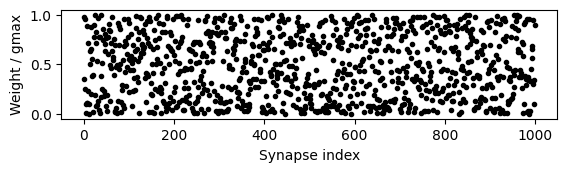

In [11]:
plt.subplot(311)
plt.plot(S.w / gmax, '.k')
plt.ylabel('Weight / gmax')
plt.xlabel('Synapse index')

각 점 = 하나의 Presynaptic 시냅스의 최종 가중치 / gmax

0.0 - 1.0 사이에 고르게 흩어져 있는데 0 근처와 1 근처에 상대적으로 많이 모여있음

-> STDP 경쟁효과 결과 (일부 시냅스는 강하게 유지 (1근처) 다른 시냅스는 약화 (0근처)



---



Text(0.5, 0, 'Weight / gmax')

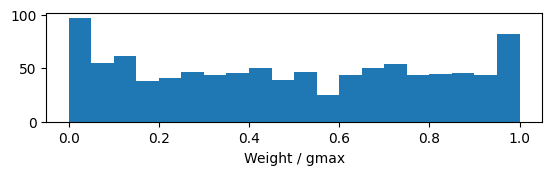

In [12]:
plt.subplot(312)
plt.hist(S.w / gmax, bins=20)
plt.xlabel('Weight / gmax')

분포가 0 근처 피크 + 1 근처 피크 -> 양극화 현상

Song & Abbott 논문에서 무상관 입력만 줘도 이런 양극화가 나타난다고 보고

-> 시냅스끼리 경쟁해서 살아남거나 죽는다는 것 보여줌



---



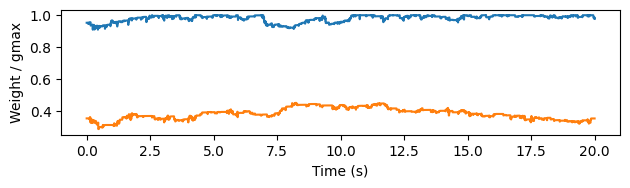

In [13]:
plt.subplot(313)
plt.plot(mon.t/second, mon.w.T/gmax)
plt.xlabel('Time (s)')
plt.ylabel('Weight / gmax')

plt.tight_layout()
plt.show()

시냅스 두개만 추적한 그래프

파란색 : 점점 1 근처로 올라가 안정적으로 유지

주황색 : 0 근처로 떨어져서 유지

-> STDP가 시냅스별로 경쟁적 선택 만듦